<a href="https://colab.research.google.com/github/abhiyantaabhishek/visualization/blob/master/Layer_activation_visualisation_pytorch_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import copy
from PIL import Image, ImageFilter
import torch
from torch.optim import Adam
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [0]:
device = torch.device('cuda:0')

In [0]:
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [0]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [0]:
def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

In [0]:
def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


In [0]:
selected_layer = 17
selected_filter = 5
model = models.vgg16(pretrained=True).features

In [0]:
model =model.to(device)

In [0]:
random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))

In [0]:
processed_image = preprocess_image(random_image, False)

In [16]:
processed_image.shape

torch.Size([1, 3, 224, 224])

In [0]:
processed_image=processed_image.to(device)

In [0]:
processed_image = Variable(processed_image.cuda(), requires_grad=True)

In [0]:
optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)

In [0]:
optimizer.zero_grad()

In [34]:
mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [35]:
processed_image.detach().cpu().numpy().shape

(1, 3, 224, 224)

In [25]:
x.shape

torch.Size([1, 512, 28, 28])

In [38]:

for i in range(1, 31):
  optimizer.zero_grad()
  x = processed_image
  #x=x.to(device)
  for index, layer in enumerate(model):
      x = layer(x)
      if index == selected_layer:
          break
  conv_output = x[0, selected_filter]
  # Loss function is the mean of the output of the selected layer/filter
  # We try to minimize the mean of the output of that specific filter
  loss = -torch.mean(conv_output)
  print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.detach().cpu().numpy()))
  loss.backward()
  optimizer.step()
  created_image = recreate_image(processed_image.detach().cpu())
  if i % 5 == 0:
      im_path = 'generated/layer_vis_l' + str(selected_layer) + \
          '_f' + str(selected_filter) + '_iter' + str(i) + '.jpg'
      save_image(created_image, im_path)


Iteration: 1 Loss: 1.33
Iteration: 2 Loss: -1.97
Iteration: 3 Loss: -8.67
Iteration: 4 Loss: -15.80
Iteration: 5 Loss: -22.68
Iteration: 6 Loss: -29.05
Iteration: 7 Loss: -35.06
Iteration: 8 Loss: -40.82
Iteration: 9 Loss: -46.39
Iteration: 10 Loss: -51.83
Iteration: 11 Loss: -57.15
Iteration: 12 Loss: -62.38
Iteration: 13 Loss: -67.57
Iteration: 14 Loss: -72.70
Iteration: 15 Loss: -77.79
Iteration: 16 Loss: -82.85
Iteration: 17 Loss: -87.87
Iteration: 18 Loss: -92.87
Iteration: 19 Loss: -97.86
Iteration: 20 Loss: -102.86
Iteration: 21 Loss: -107.87
Iteration: 22 Loss: -112.88
Iteration: 23 Loss: -117.90
Iteration: 24 Loss: -122.92
Iteration: 25 Loss: -127.96
Iteration: 26 Loss: -133.02
Iteration: 27 Loss: -138.12
Iteration: 28 Loss: -143.21
Iteration: 29 Loss: -148.32
Iteration: 30 Loss: -153.46


In [0]:
col = 3
row = len(os.listdir('generated'))//3 +(len(os.listdir('generated'))-len(os.listdir('generated'))//3*3)

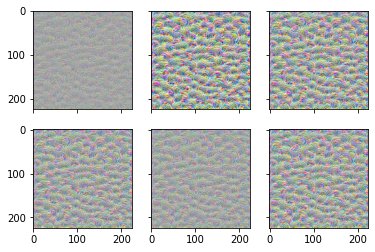

In [40]:
files = os.listdir('generated')
fig, ax = plt.subplots(row, col, sharex='col', sharey='row')
ind=0
for i in range(row):
    for j in range(col):
      im = plt.imread('generated/'+files[ind])
      ax[i, j].imshow(im)
      ind=ind+1